### Syscoin 4.0 Research: Modeling Gas Fees for SYSX 
* Model of ETH Gas costs
    * Baysian inference using Gaussian Processes
    * General Mixture models
    * Kernel Density Estimator

In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
import theano.tensor as tt
import random
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm

from pomegranate import *
from matplotlib import pyplot
from numpy.random import normal
from numpy import hstack
from numpy import asarray
from numpy import exp
from sklearn.neighbors import KernelDensity
from pymc3.gp.util import plot_gp_dist

In [2]:
def func_exp(x, a, b, c):
    """Return values from a general exponential function."""
    return a * np.exp(b * x) + c

def func_log(x, a, b, c):
    """Return values from a general log function."""
    return a * np.log(b * x) + c

def generate_data(func, *args, jitter=0, xs):
    """Return a tuple of arrays with random data along a general function."""
    ys = func(xs, *args)
    noise = jitter * np.random.normal(size=len(xs)) + jitter
    xs = xs.reshape(-1, 1)                                  # xs[:, np.newaxis]
    ys = (ys + noise).reshape(-1, 1)
    return xs, ys

def invlogit(x, s):
    return np.exp(x+s) / (1 + np.exp(x+s))

def scale_x(x, k, x0, y0):
    return k*(x-x0) + np.log(y0/(1-y0)) 

def logit2(x,k,x0,y0):
    return (1/k)*np.log(x/(1-x)) + y0 - (1/k)*np.log(x0/(1-x0))

def blk_occ_m1(x,k,x0,y0):
    return (1/k)*np.log((1+x)/(1-x)) + y0 

def blk_occ_m2(x,k,x0,y0):
    return np.abs(1/(k*(x-1)))+y0-1/k

def gen_block_occupancy(N):
    
    empty_dataset = np.zeros(N)
    mod = sm.tsa.SARIMAX(empty_dataset, order=(1, 1, 1), initialization='diffuse')
    simulations = mod.simulate([0.5, -5/3, 5/6, 4**2], N)
    t = np.array(range(1,N+1))

    shape, scale = 100, 3  
    s = np.random.gamma(shape, scale, N)

    x_samp, y_samp = generate_data(func_log, 1, 1.2, 0.7, xs=t)

    sim = (s + np.abs(simulations))*np.exp(y_samp.flatten())
    sim_block_occupancy = np.abs(simulations)/max(np.abs(simulations))
    
    return sim_block_occupancy

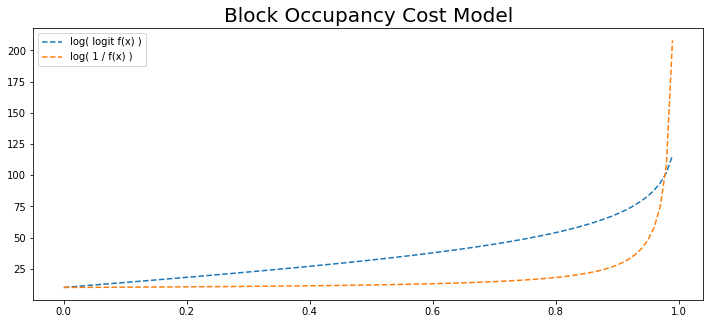

In [3]:
x0 = 0; y0 = 10; 
blk_occupancy = np.arange(0,1,0.01)

k = 0.05
cost_m1 = blk_occ_m1(blk_occupancy, k, x0, y0)

k = 0.5
cost_m2 = blk_occ_m2(blk_occupancy, k, x0, y0)

plt.figure(figsize=(12,5))
plt.plot(blk_occupancy, cost_m1, linestyle='--', label='log( logit f(x) )')
plt.plot(blk_occupancy, cost_m2, linestyle='--', label='log( 1 / f(x) )')
plt.title("Block Occupancy Cost Model", fontsize=20)
plt.legend();

Text(0.5, 1.0, 'Block Occupancy Simulations')

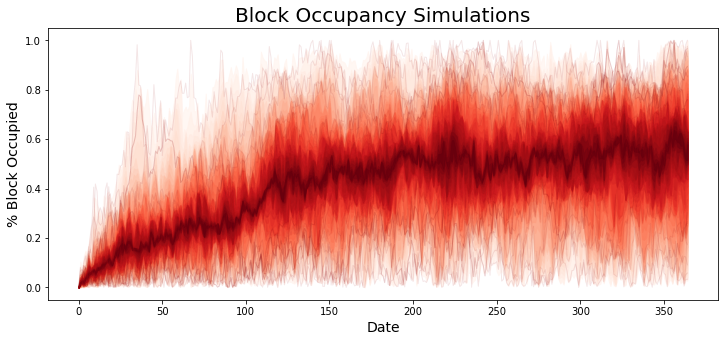

In [4]:
N = 365
t = np.array(range(0,N))
sim = gen_block_occupancy(N).reshape(-1,1)
for k in range(1,50):
    blk_occupancy = gen_block_occupancy(N).reshape(-1,1)
    sim = np.hstack((sim,blk_occupancy))

fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
plot_gp_dist(ax, sim.transpose(), t)
plt.ylabel("% Block Occupied", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.title("Block Occupancy Simulations", fontsize=20)

In [5]:
sim_t = sim.transpose()

(0.0, 100.0)

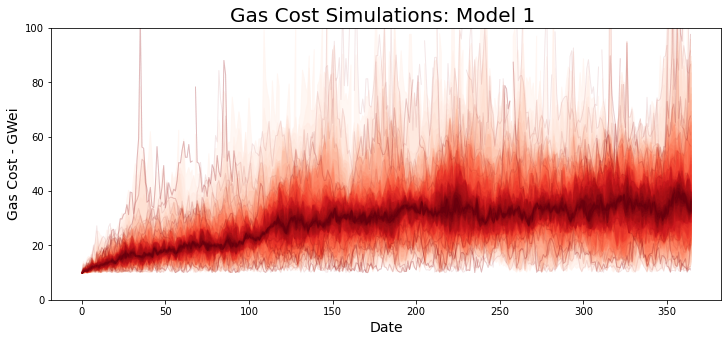

In [8]:
sim_cost_m1 = blk_occ_m1(sim_t[0], 0.05, x0, y0).reshape(-1,1)
for k in range(1,50):
    cost_m1 = blk_occ_m1(sim_t[k], 0.05, x0, y0).reshape(-1,1)
    sim_cost_m1 = np.hstack((sim_cost_m1,cost_m1))
    
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
plot_gp_dist(ax, sim_cost_m1.transpose(), t)
plt.ylabel("Gas Cost - GWei", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.title("Gas Cost Simulations: Model 1 ", fontsize=20)
plt.ylim((0,100))

(0.0, 100.0)

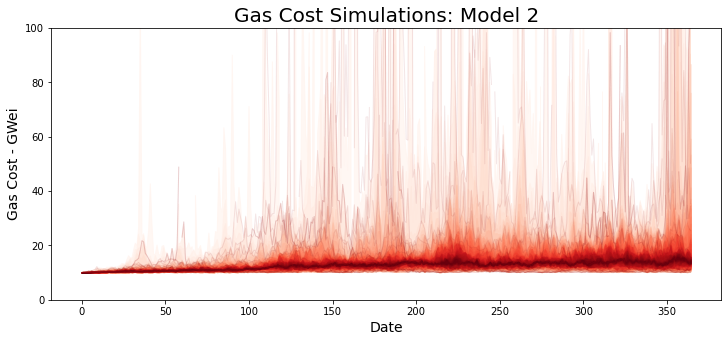

In [11]:
sim_cost_m2 = blk_occ_m2(sim_t[0], 0.3, x0, y0).reshape(-1,1)
for k in range(1,50):
    cost_m2 = blk_occ_m2(sim_t[k], 0.3, x0, y0).reshape(-1,1)
    sim_cost_m2 = np.hstack((sim_cost_m2,cost_m2))
    
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
plot_gp_dist(ax, sim_cost_m2.transpose(), t)
plt.ylabel("Gas Cost - GWei", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.title("Gas Cost Simulations: Model 2", fontsize=20)
plt.ylim((0,100))